In [3]:
import numpy as np
#import myfun as mf
import copy

import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

from sklearn import naive_bayes as NB
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from numpy import linalg as linalg
from importlib import reload

from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import minimize, basinhopping, dual_annealing

import networkx as nx
#import emcee

In [4]:
deck=np.hstack([[i for j in range(4) for i in range(1,10)],10*np.ones(16)])

In [5]:
win_sums = [10,20,30]
def get_set(pile):
    if len(pile) < 3:
        return None
    elif len(pile) == 3:
        if sum(pile)%10==0:
            return [-3,-2,-1]
        else: 
            return None
    else:
        bot3_sum = sum(pile[-3:])
        bot2_sum = pile[-2] + pile[-1] + pile[0]
        bot1_sum = pile[-1] + pile[0]  + pile[1]
        
        if bot1_sum%10 ==0:
            return [-1,0,0] # because its used for pop, once you pop off 0, 1-->0
        elif bot2_sum%10 ==0:
            return [-2,-1,0]
        elif bot3_sum%10 ==0:
            return [-3,-2,-1]
        else:
            return None

In [6]:
win_sums         = [10,20,30]
idxs2pop         = [[-3,-2,-1], [-2,-1,0], [-1,0,0]]
remaining_slices = [[0,-3], [1,-2], [2,-1]]

# []  --> None
# [0] --> bot 3
# [1] --> bot 2 top 1
# [2] --> bot 1 top 2

def get_set_strat(pile):
    if len(pile) < 3:
        return []
    elif len(pile) == 3:
        if sum(pile)%10==0:
            return [0]
        else: 
            return []
    else:
        bot_sums    = np.zeros(3)
        bot_sums[0] = sum(pile[-3:])
        bot_sums[1] = pile[-2] + pile[-1] + pile[0]
        bot_sums[2] = pile[-1] + pile[0]  + pile[1]
        
        #bot_sums_mod10  = bot_sums % 10
        mod10_zero_idxs = np.where(bot_sums % 10 == 0)[0]
        
        if len(mod10_zero_idxs) == 0:
            return []
        elif len(mod10_zero_idxs) == 1:
            return [mod10_zero_idxs[0]]
        else:
            # first check if any more sets...
            all_sets = [[] for i in range(len(mod10_zero_idxs))]
            for i,idx in zip(range(len(mod10_zero_idxs)),mod10_zero_idxs):
                all_sets[i] = [idx] + get_set_strat(
                    pile[remaining_slices[idx][0]:remaining_slices[idx][1]]
                )
            
            n_all_sets    = np.array([len(x) for x in all_sets])
            print(all_sets)
            print(n_all_sets)
            best_set_idxs = mod10_zero_idxs[np.argwhere(n_all_sets == np.amax(n_all_sets)).flatten()]
            if len(best_set_idxs == 1): # a clear winner
                return [best_set_idxs[0]]
            else:
                
                # take the top cards
                return [np.amax(best_set_idxs)]
                
                # other possible rules
                # take things that are doubled (e.g., 8-8-4)
                # leave 10s on top
                # leave sums of 10 (0:2) on top

In [134]:
#idxs2pop         = [[-3,-2,-1],[-2,-1,0]]

def play_game(seed=None, npiles_init = 7, max_iter = 1000):
    
    np.random.seed(seed)

    won        = False
    piles      = [[] for i in range(npiles_init)]
    
    shuf       = np.random.choice(np.arange(ncards),size=ncards,replace=False)
    game_deck  = list(np.array(deck[shuf],dtype=int))
    pos        = 0
    remove_idx = -1
    iter_ct    = 0 
    while len(game_deck)>0 and not won and iter_ct < max_iter:
        iter_ct += 1
        for i in range(pos,len(piles)):

            piles[i].append(game_deck.pop(0))

            #set_idxs = get_set(piles[i])
            set_pick = get_set_strat(piles[i])
            set_idxs = idxs2pop[set_pick[0]] if len(set_pick) > 0 else None
            while set_idxs:
                for idx in set_idxs:
                    game_deck.append(piles[i].pop(idx))
                set_idxs = get_set(piles[i])

            if len(piles[i]) == 0:
                remove_idx = i
                break

            if len(game_deck) == 0: # lost
                break

        if remove_idx > -1:
            piles.pop(remove_idx)
            if len(piles) == 0: # won
                won = True
            pos = copy.copy(remove_idx)
            remove_idx = -1
        else:
            pos = 0
    
    return piles, game_deck, iter_ct

9

In [273]:
win_sums         = [10,20,30]
idxs2sum         = [[-3,-2,-1], [-2,-1,0], [-1,0,1]]
nopt             = len(idxs2sum)
idxs2pop         = [[-3,-2,-1], [-2,-1,0], [-1,0,0]]
remaining_slices = [[0,-3], [1,-2], [2,-1]]

def get_sets(pile, sets):
    #print(pile)
    if len(sets)>0 and sets[-1] is None:
        return sets
    elif len(pile) < 3:
        return sets+[None]
    else:
        on_sets = [None, None, None]
        for i in range(nopt):
            if sum(pile[idxs2sum[i]])%10==0:
                on_sets[i] = i
        
#         return [get_sets(pile[remaining_slices[i][0]:remaining_slices[i][1]], sets+[on_sets[i]]) 
#                 for i in range(nopt)]
        return get_sets(pile[remaining_slices[0][0]:remaining_slices[0][1]], sets+[on_sets[0]])+\
               get_sets(pile[remaining_slices[1][0]:remaining_slices[1][1]], sets+[on_sets[1]])+\
               get_sets(pile[remaining_slices[2][0]:remaining_slices[2][1]], sets+[on_sets[2]])

def get_sets_split(pile):
    seq         = get_sets(pile, [])
    seqs_split  = []
    current_seq = []
    for i in range(len(seq)):
        if seq[i] is not None:
            current_seq = current_seq + [seq[i]]
        else:
            if len(current_seq) > 0:
                seqs_split.append(tuple(current_seq))
            current_seq = []
    return list(set(seqs_split))

def get_best_set(pile):
    seqs         = get_sets_split(pile)
    
    if len(seqs) == 0: # no sets
        return ()
    
    
    set_len      = np.array([len(x) for x in seqs])
    max_len      = np.amax(set_len)
    longest_runs = np.where(set_len==max_len)[0]
    
    if len(longest_runs) == 1: # one best set sequence
        return seqs[longest_runs[0]]
    
    if len(pile) == 3: # common practice...
        return (0,)

    #set_entropy = np.array([sum(seqs[i]) for i in longest_runs])
    #set_pick = np.argmax(set_entropy)
    set_pick = np.random.choice(len(longest_runs))
    return seqs[longest_runs[set_pick]]

In [274]:
def play_game(seed=None, npiles_init = 7, max_iter = 1000):
    
    np.random.seed(seed)

    won        = False
    piles      = [[] for i in range(npiles_init)]
    
    shuf       = np.random.choice(np.arange(deck.shape[0]),size=deck.shape[0],replace=False)
    game_deck  = list(np.array(deck[shuf],dtype=int))
    pos        = 0
    remove_idx = -1
    iter_ct    = 0 
    while len(game_deck)>0 and not won and iter_ct < max_iter:
        iter_ct += 1
        
        # iterate through the piles
        for i in range(pos,len(piles)):
            piles[i].append(game_deck.pop(0))
            #print(piles[i])
            sets2pop = get_best_set(np.array(piles[i]))
            for j in sets2pop:
                for idx in idxs2pop[j]:
                    game_deck.append(piles[i].pop(idx))

            if len(piles[i]) == 0:
                remove_idx = i
                break

            if len(game_deck) == 0: # lost
                break

        if remove_idx > -1:
            piles.pop(remove_idx)
            if len(piles) == 0: # won
                won = True
            pos = copy.copy(remove_idx)
            remove_idx = -1
        else:
            pos = 0
    
    return piles, game_deck, iter_ct

In [275]:
ngames = 10000
ps     = [play_game(max_iter=500) for i in range(ngames)]

In [276]:
npiles = np.array([len(gm[0]) for gm in ps])
nmoves = np.array([gm[2] for gm in ps])

(array([ 209.,    3.,  274.,  709., 1442., 2560., 2933., 1870.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

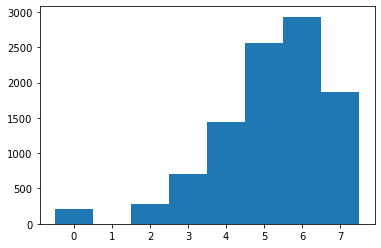

In [277]:
fig,axs=plt.subplots()
axs.hist(npiles, bins=np.arange(-0.5,8.5,1))

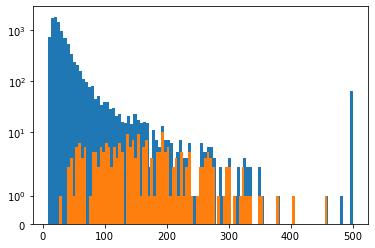

In [279]:
fig,axs=plt.subplots()
axs.hist(nmoves, bins=100)
axs.hist(nmoves[npiles==0], bins=100)

axs.set_yscale('symlog')

In [261]:
play_game(max_iter=5000)

([[9, 8, 5, 8, 10, 3, 6, 7, 1],
  [2, 10, 10, 7, 5, 10, 1, 4, 7, 10, 1, 10],
  [3, 10, 2, 5, 10, 6, 9, 6, 10, 5, 10, 4, 10, 8],
  [8, 1, 4, 10, 2, 10, 4, 10, 10, 3, 3, 2, 9, 6, 7, 10, 9]],
 [],
 27)

In [262]:
get_best_set(np.array([5,4]))

()

In [192]:
for i in get_best_set(np.array([3, 10, 10, 10])):
    for j in idxs2pop[i]:
        print(j)

-3
-2
-1


In [177]:
a=['a','b','c']
b=['d','e','f','g','h','i','j']
a,b

(['a', 'b', 'c'], ['d', 'e', 'f', 'g', 'h', 'i', 'j'])

In [178]:
for i in get_best_set(np.array([10,10,3, 10, 10,7, 10])):
    for j in idxs2pop[i]:
        a.append(b.pop(j))

In [190]:
get_best_set(np.array([2,1]))

()

In [154]:
idxs2pop[0]

[-3, -2, -1]

In [254]:
[ps[x][1] for x in np.where(npiles==1)[0]]

[[3,
  1,
  7,
  2,
  1,
  6,
  10,
  4,
  8,
  7,
  5,
  10,
  10,
  10,
  10,
  10,
  10,
  4,
  8,
  8,
  5,
  10,
  5,
  10,
  10,
  10,
  1,
  1,
  8,
  3,
  4,
  3,
  6,
  10,
  4,
  7,
  10,
  3],
 [5, 2, 6, 8, 6, 10, 10, 10, 4, 8, 8, 10, 10, 10, 10, 10, 10, 10, 9, 1],
 [10,
  10,
  10,
  10,
  10,
  4,
  5,
  1,
  2,
  8,
  10,
  4,
  10,
  6,
  3,
  2,
  5,
  8,
  7,
  5,
  8,
  3,
  9,
  5,
  3,
  2,
  10,
  10,
  10,
  6,
  6,
  8],
 [10, 2, 1, 10, 9, 10, 8, 2, 10, 1, 9, 10, 3, 7, 10, 10, 10, 6, 3, 1, 6, 2, 2],
 [10, 1, 10, 10, 10, 10, 8, 2, 10, 3, 7, 4, 2, 4, 4, 10, 6, 3, 10, 7, 9, 5, 6],
 [10,
  5,
  2,
  10,
  8,
  3,
  9,
  8,
  10,
  1,
  9,
  4,
  6,
  10,
  10,
  10,
  10,
  9,
  1,
  10,
  10,
  10,
  10,
  7,
  5,
  8,
  10,
  8,
  2,
  4,
  7,
  9,
  10,
  6,
  4],
 [1,
  4,
  10,
  8,
  2,
  10,
  10,
  10,
  4,
  10,
  6,
  10,
  3,
  7,
  3,
  3,
  4,
  8,
  10,
  2,
  4,
  10,
  6,
  10,
  10,
  10,
  9,
  1,
  10,
  3,
  5,
  2]]

In [211]:
len(np.where(npiles==0)[0])

18

In [124]:
i=0
for i in ():
    i=i+1

In [91]:
m=[]
m.append(list(range(5)))
m.append(list(range(6,15)))

m

[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13, 14]]

In [105]:
set([(0,0,1),(0,1,0),(1,0,0)])

{(0, 0, 1), (0, 1, 0), (1, 0, 0)}

In [118]:
pile = np.array([2,4,10,10,4,4,10,9,1,7,8,5])
#get_sets(pile,[])
m=get_sets_split(pile)
n=np.array([len(x) for x in m])
n,np.argmax(n)
get_best_set(pile)

(0, 0, 2)

In [219]:
bins = np.arange(0,9)
bcs = np.histogram(npiles,bins,density=True)[0]
bin_ctrs = 0.5*(bins[1:]+bins[:-1])

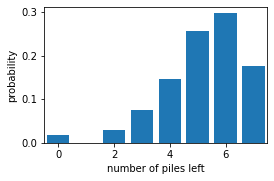

In [220]:
fig,axs=plt.subplots(figsize=(4,2.5))
axs.bar(bins[:-1],bcs)
axs.set_xlim(-0.5,7.5)
#axs.set_yscale('log')
axs.set_xlabel('number of piles left')
axs.set_ylabel('probability')
plt.show()

In [222]:
bcs

array([0.0184, 0.0003, 0.0298, 0.0744, 0.1474, 0.2559, 0.2968, 0.177 ])

In [227]:
np.where(npiles==1)

(array([ 902, 5020, 8159]),)

In [ ]:
gm

In [226]:
1/54

0.018518518518518517

In [122]:
if None:
    print('hi')

In [132]:
get_best_set(np.array([2,8,10]))

(0,)

In [129]:
get_sets_split(np.array([2,8,10]))

[(0,), (1,), (2,)]

In [148]:
import networkx as nx
nx.from_nested_tupleted_tuple([get_sets(np.array([2,8,10,10,10,10,10,9,1]),i) for i in range(3)])

AttributeError: module 'networkx' has no attribute 'from_nested_tupleted_tuple'

In [150]:
nx.__version__

'2.5'

In [117]:
play_game()

([[7, 5, 2, 7, 4, 5, 10, 10, 7],
  [3, 9, 7, 2, 10, 6, 10, 5, 4],
  [3, 10, 1, 3, 10, 8, 4, 6, 6],
  [1, 10, 10, 8, 4, 10, 1, 10, 10],
  [8, 5, 10, 1, 2, 9, 10, 8, 9, 10, 3],
  [9, 6, 2, 10, 10]],
 [],
 16)

In [74]:
ngames = 20000
ps     = [play_game(max_iter=5000) for i in range(ngames)]

In [77]:
npiles = np.array([len(gm[0]) for gm in ps])
nmoves = np.array([gm[2] for gm in ps])

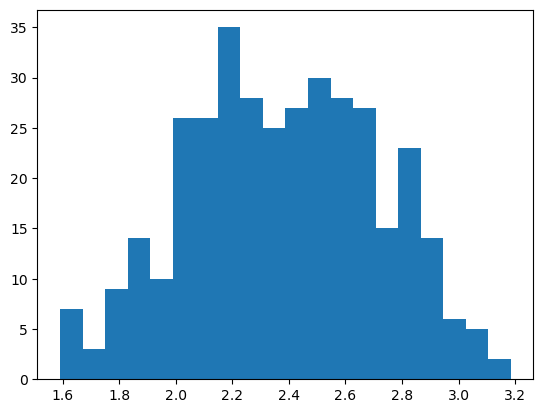

In [78]:
fig,axs=plt.subplots()
axs.hist(np.log10(nmoves[np.where(npiles==0)]),bins=20)
#axs.set_xscale('log')
plt.show()

In [80]:
ncards = len(deck)
ngames = 100

In [81]:
bcs

array([0.018  , 0.01185, 0.0523 , 0.08595, 0.1813 , 0.2608 , 0.24025,
       0.14955])

In [9]:
#np.array_equal(np.sort(deck[shuf]),np.sort(deck))

In [242]:
#z=[]
#idxs2pop[z[0]]

IndexError: list index out of range

In [346]:
bcs

array([0.022, 0.026, 0.06 , 0.157, 0.238, 0.318, 0.179])

In [157]:
p,d,ic = play_game(seed=1)

In [86]:
np.array_equal(np.sort(mf.flatten2d(piles)),np.sort(deck))

True

In [72]:
piles

[[10.0, 9.0, 7.0],
 [3.0],
 [10.0, 8.0],
 [7.0, 10.0],
 [5.0, 4.0],
 [9.0, 6.0],
 [1.0, 10.0]]